In [242]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binom


def err(hist, a):
    [c_4, c_3, c_2, c_1] = hist
    return (c_3 - c_1 + (c_2 - c_3) * a)**2 + (c_4 - c_2 + (c_3 - c_4) * a)**2


def pred(hist, a):
    [c_4, c_3, c_2, c_1] = hist
    return a * c_1 + (1 - a) * c_2


def plot_errs(hist):
    x = np.arange(-1, 1.01, 0.01)
    y = err(hist, x)
    going = pred(hist, x)

    mask = np.where(going < 60)
    plt.plot(x[mask],y[mask], color="blue")

    mask = np.where(going >= 60)
    plt.plot(x[mask],y[mask], color="orange")

    plt.xlabel("a")
    plt.ylabel("Error")
    plt.legend(["going", "not going"])
    _ = plt.title(hist)
    
    
def binom_p_value(k, n, p):
    if k < n * p:
        return binom.cdf(k, n, p)
    else:
        return binom.sf(k, n, p)

    
def assert_equal(a, b, msg):
    assert (np.abs(a - b) < 1e-6).all(), msg
    

def assert_less(a, b, msg):
    assert (a - b < 1e-6).all(), msg

    
def assert_geq(a,b,msg):
    assert (a - b > -1e-6).all(), msg


class BarModel:
    def __init__(
        self,
        hist, 
        s, 
        x_min, 
        x_max
    ):
        try:
            self.predict(hist, s, x_min, x_max)
        except AssertionError as E:
            self.error = E
            print(E)
        
    def predict(self, hist, s, x_min, x_max):
        # write the errors as a quadratic eqation
        [c_4, c_3, c_2, c_1] = hist

        self.a_1 = (c_2 - c_3)**2 + (c_3 - c_4)**2
        self.a_2 = 2 * ((c_2 - c_3) * (c_3 - c_1) + (c_3 - c_4) * (c_4 - c_2))
        self.a_3 = (c_3 - c_1)**2 + (c_4 - c_2)**2

        # check work
        x = np.arange(-1, 1.01, 0.01)
        y = err(hist, x)
        y_2 = (self.a_1 * x**2 + self.a_2 * x + self.a_3)

        assert_equal( (y_2 - y).max(), 0, "Check your coefficients!")
        
        # check for degenerate  case
        # when prediction is a constant
        # equal to c_1
        if c_1 == c_2:
            self.p_go = 1 * (c_1 < 60)
            self.case = "0"
            return
        
        # threshold
        self.t = (60 - c_2) / (c_1 - c_2)

        # whether or not prediction is increasing
        # determines which regions of the map are going
        # this inequality follows from the predictor
        # for time t
        self.increasing = c_1 > c_2
        
        # threshold lower than entire window
        if self.t < x_min:
            self.p_go = 1 - self.increasing
            self.case = f"1_{self.increasing}"
            return
        
        # threshold above entire window
        if self.t >= x_max:
            self.p_go = 1 * self.increasing
            self.case = f"2_{self.increasing}"
            return
        
        # when err function is a constant
        # when a_1 is 0, a_2 should also be 0
        # so this is convenient
        if self.a_1 == 0:
            assert self.a_2 == 0
            
            if self.increasing:
                self.p_go = (self.t - x_min) / (x_max - x_min)
            else:
                self.p_go = (x_max - self.t) / (x_max - x_min)

            self.case = f"-1_{self.increasing}"
            return
            
        # optimal A is min of error curve
        self.opt_a = -self.a_2 / (2*self.a_1)

        assert_geq (y.min(), err(hist, self.opt_a), "Opt_a isn't minimum!")

        
        # is the bottom part going
        # TODO: DO we need this?
        inc_going = self.increasing and self.t > self.opt_a
        dec_going = not self.increasing and self.t <= self.opt_a
        self.bottom_part_going = inc_going or dec_going
        
        # find coordinates of bottom region
        # reflection of threshold about *opt_a*
        self.t_ref  = 2 * self.opt_a - self.t

        assert_equal(self.opt_a - self.t_ref, self.t - self.opt_a, "reflected thresholds not symmetrical")
        
        # to get the bottom part we need the left-hand
        # and right-hand sides of the threshold
        self.t_l = min(self.t, self.t_ref)
        self.t_r = max(self.t, self.t_ref)

        assert_equal(self.opt_a - self.t_l, self.t_r - self.opt_a, "right and left thresholds not symmetrical")
        
        # reflection of LHS of window across threshold
        # this is the righthand boundary of the symmetric region
        self.ref_r = 2 * self.opt_a - x_min

        assert_equal(self.opt_a - x_min, self.ref_r - self.opt_a, "ref_r not symmetrical")

        # reflection of RHS of window across threshold
        # this is the lefthand boundary of the symmetric region
        self.ref_l = 2 * self.opt_a - x_max

        assert_equal(x_max - self.opt_a, self.opt_a - self.ref_l, "ref_l not symmetrical")

        
        # For the remaining cases we can now
        # assume that threshold is inside of
        # the window

        # threshold to the left of all points other 
        # interesting things.
        # agents will always pick a > t
        # when possible
        if self.t < self.ref_l:
            # the probability that an arbitrary a > t
            self.p_optimal_region = (x_max - self.t) / (x_max - x_min)
            self.p_any_optimal_region = 1 - (1 - self.p_optimal_region)**s
            self.p_go = self.p_any_optimal_region * (1 - self.increasing) + (1 - self.p_any_optimal_region) * self.increasing
            self.case = f"3_{self.increasing}"
            return
        
        # threshold within window
        # and asymmetric region on the left
        # (or perfectly symmetric)
        elif self.t >= self.ref_l and self.ref_l >= x_min:
            assert_geq( self.ref_r,  x_max, "ref_r < x_max")
            assert_less( self.opt_a, x_max, "opt_a >= x_max")
            
            # the probability that a is in the bottom region
            self.p_optimal_region = (self.t_r - self.t_l) / (x_max - x_min)
            self.p_any_optimal_region = 1 - (1 - self.p_optimal_region) ** s
            self.p_go_optimal = self.p_any_optimal_region * self.bottom_part_going
            
            # the probability that a is in the lefthand asymmetric region
            self.p_left_side = (self.ref_l - x_min) / (x_max - x_min)
            self.p_all_left_side = self.p_left_side ** s
            self.p_go_left_side = self.p_all_left_side * self.increasing
            
            self.p_sym = 1 - self.p_any_optimal_region - self.p_all_left_side
            assert_geq( self.p_sym, 0, "Negative probability.  Oh no!")
            self.p_go_sym = 0.5 * self.p_sym
            
            self.p_go = self.p_go_optimal + self.p_go_left_side + self.p_go_sym
            self.case = f"4_{self.increasing}"
            return
        
        # threshold within window
        # and asymmetric region on the right
        elif self.t < self.ref_r and self.ref_r < x_max:
            assert_less( self.ref_l, x_min, "ref_r >= x_min")
            assert_geq( self.opt_a, x_min, "opt_a < x_min")
            
            # the probability that a is in the bottom region
            self.p_optimal_region = (self.t_r - self.t_l) / (x_max - x_min)
            self.p_any_optimal_region = 1 - (1 - self.p_optimal_region) ** s
            self.p_go_optimal = self.p_any_optimal_region * self.bottom_part_going
            
            # the probability that a is in the righthand asymmetric region
            self.p_right_side = (x_max - self.ref_r) / (x_max - x_min)
            self.p_all_right_side = self.p_right_side ** s
            self.p_go_right_side = self.p_all_right_side * (1 - self.increasing)
            
            self.p_sym = 1 - self.p_any_optimal_region - self.p_all_right_side
            assert_geq( self.p_sym, 0, "Negative probability.  Oh no!")
            self.p_go_sym = 0.5 * self.p_sym
            
            self.p_go = self.p_go_optimal + self.p_go_right_side + self.p_go_sym
            self.case = f"5_{self.increasing}"
            return
        
        # threshold within window
        # but to the right of all points other 
        # interesting things.
        # agents will always pick a <= t
        # when possible
        elif self.t >= self.ref_r:
            self.p_optimal_region = (self.t - x_min) / (x_max - x_min)
            self.p_any_optimal_region = 1 - (1 - self.p_optimal_region)**s
            self.p_go = self.p_any_optimal_region * self.increasing + (1 - self.p_any_optimal_region) * (1 - self.increasing) 
            self.case = f"6_{self.increasing}"
            return
        
        else:
            assert False, "Missing case!"


def make_strategies(rng, strategies, memory):
    # weights should sum to 1
    # essentially, we are partitioning the [0,1] interval
    # and taking the size of each sub-interval
    # TODO: add negative weights?
    w = rng.uniform(-1, 1, size=(strategies, memory-1))
    w.sort(axis=1)
    offsets = np.hstack([w[:, :], np.ones(shape=(strategies,1))])
    return offsets - np.hstack([np.zeros(shape=(strategies,1)), w[:, :]])

def run_test(
    start,
    agents,
    strategies,
    trials,
    seed
):
    # number of weeks back in predictor function
    # AND number of weeks back to look when selecting a predictor
    memory = 2
    # number of rounds to run the simulation
    n_iter = 1
    threshold = 60
    
    x_min = -1
    x_max = 1
    
    model = BarModel(start, strategies, x_min, x_max)
    p = model.p_go
    print(f"Case: {model.case}")
    print(f"We expect agents to attend with probability {p}.")
    print(f"Total weekly attendance should have mean {agents * p} and variance {agents * p * (1-p)}")
    
    results = np.empty(trials)

    rng = np.random.default_rng(seed)

    for tr in range(trials):
        # each row is a strategy
        strats = [
            make_strategies(rng, strategies, memory) for _ in range(agents)
        ]

        # weekly attendance count
        # the first 2*memory weeks are randomly generated
        # to seed the strategies
        hist = np.hstack([start, np.zeros(n_iter)]).astype(int)

        # index of week
        # we need some starting history to begin making selections
        t = memory * 2

        # Record the index of the optimal strategy 
        # on each iteration.
        # each row corresponds to an agent
        # each column corresponds to a week
        best_strats = np.zeros((agents, len(hist)))

        # record each agent's prediction on each iteration
        pred_history = np.zeros((agents, len(hist)))

        # construct time windows for evaluating strategies

        # The columns begin at
        # t - m - 1 
        # t - m
        # ...
        # t - 1
        # t
        # as you go down the column you are looking back
        # to that week's history.
        # so the column beginning at *t - m - 1*
        # generates the prediction for week *t - m*
        # and the rightmost column generates a
        # prediction for next week.
        windows = np.vstack([
            hist[t-memory-i-1: t-i]
            for i in range(memory)
        ])

        for agent in range(agents):
            strat = strats[agent]
            # each row is a strategy
            # each column is predicted attendance
            # in increasing order.
            # the last column has the prediction for
            # next week
            predictions = strat.dot(windows)

            # these are the observations that we use to
            # to test our predictions.
            # note that the observation from column 0
            # is not used since its prediction would come
            # from a previous week's history.
            observations = windows[0, 1:]

            # calculate the absolute error of predictions
            # here, we discard the rightmost prediction as
            # this is the prediction for the future.
            # if we knew the correct answer for that,
            # we wouldn't need to predict it!
            errs = np.abs(predictions[:, :-1] - observations).sum(axis=1)

            best_strat = np.argmin(errs)
            best_strats[agent, t] = best_strat

            pred = strat[best_strat].dot(windows[:,-1])
            pred_history[agent, t] = pred

        hist[t] = (pred_history[:, t] < threshold).sum()
        results[tr] = hist[t]

    plt.figure()
    plt.hist(results)

    print(f"Average attendance: {results.mean()}")
    print(f"Variance of attendance: {results.var()}")
    
    # individual trials have attendance distributed
    # binom(agents, p)
    
    # attendance of the full experiment should be distributed
    # binom(trials * agents, p)
    
    n = trials * agents
    print(f"P-value: {binom_p_value(results.sum(), n, p)}")

# Analyze the cases
Find an example of each case.  Are there additional cases that we have not considered?

In [205]:
# save an example of each case for testing
cases = dict()
strategies = 2
rng = np.random.default_rng(27)

n_iter = 0
while n_iter < 10000 or len(cases) < 15:
    n_iter += 1
    start = rng.choice(100, size=(4,))
    model = BarModel(start, strategies, x_min, x_max)
    
    if model.case not in cases:
        cases[model.case] = start
    
cases

{'2_True': array([ 0, 69, 21, 31]),
 '4_False': array([98, 12, 59, 32]),
 '5_True': array([43, 93, 19, 78]),
 '2_False': array([31, 29, 98, 94]),
 '5_False': array([29, 40, 64, 18]),
 '6_True': array([39, 86,  0, 90]),
 '3_False': array([45, 75, 65, 26]),
 '3_True': array([16, 11, 74, 89]),
 '1_False': array([24, 97, 22,  1]),
 '1_True': array([72,  0, 90, 99]),
 '0': array([ 7, 83, 95, 95]),
 '6_False': array([77, 68, 90, 29]),
 '4_True': array([37,  0, 51, 65]),
 '-1_True': array([ 9,  9,  9, 77]),
 '-1_False': array([71, 71, 71,  4])}

In [206]:
sorted(cases.keys())

['-1_False',
 '-1_True',
 '0',
 '1_False',
 '1_True',
 '2_False',
 '2_True',
 '3_False',
 '3_True',
 '4_False',
 '4_True',
 '5_False',
 '5_True',
 '6_False',
 '6_True']

Okay this looks good.  Is
## Case -1
correct?

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


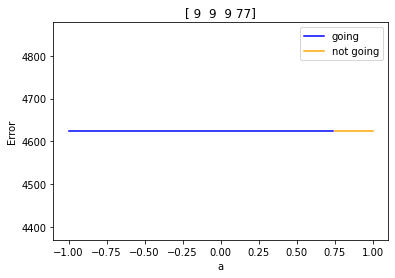

In [207]:
start = cases["-1_True"]
plot_errs(start)

Case: -1_True
We expect agents to attend with probability 0.875.
Total weekly attendance should have mean 87.5 and variance 10.9375
Average attendance: 87.5182
Variance of attendance: 10.658068759999999
P-value: 0.3479660169323927


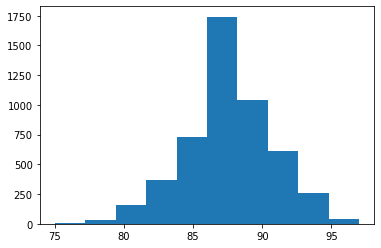

In [208]:
agents = 100
strategies = 2
trials = 5000
seed = 227334

run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


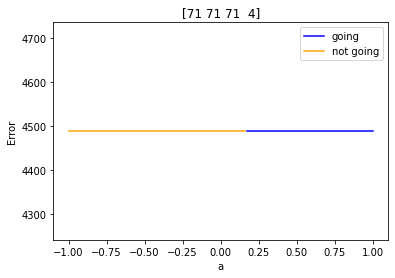

In [209]:
start = cases["-1_False"]
plot_errs(start)

Case: -1_False
We expect agents to attend with probability 0.417910447761194.
Total weekly attendance should have mean 41.7910447761194 and variance 24.326130541323234
Average attendance: 41.7952
Variance of attendance: 24.177256959999998
P-value: 0.4756461855378184


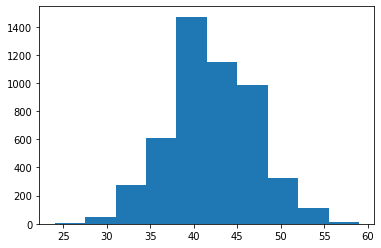

In [210]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

That looks good...  How about
## Case 0

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


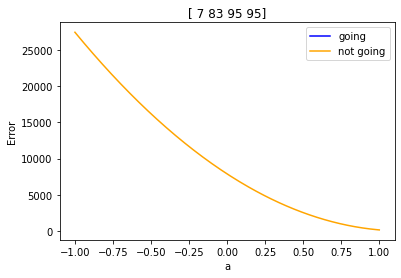

In [214]:
start = cases["0"]
plot_errs(start)

Case: 0
We expect agents to attend with probability 0.
Total weekly attendance should have mean 0 and variance 0
Average attendance: 0.0
Variance of attendance: 0.0
P-value: 0.0


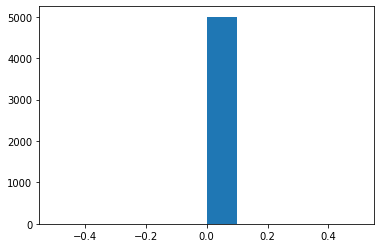

In [215]:
agents = 100
strategies = 2
trials = 5000
seed = 8888

run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


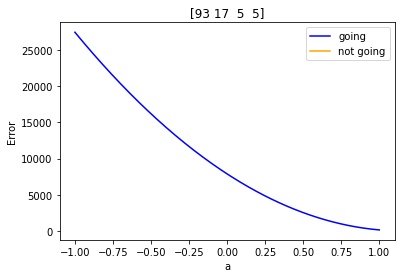

In [216]:
start = 100 - cases["0"]
plot_errs(start)

Case: 0
We expect agents to attend with probability 1.
Total weekly attendance should have mean 100 and variance 0
Average attendance: 100.0
Variance of attendance: 0.0
P-value: 0.0


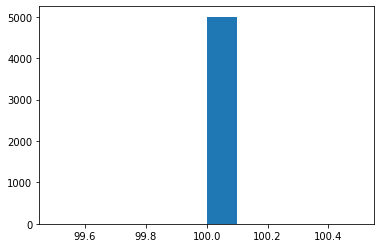

In [217]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

Whooo!  Looks good.  Now let's try
## Case 1

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


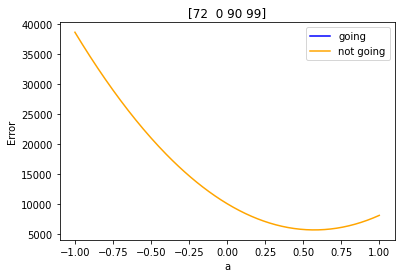

In [212]:
start = cases["1_True"]
plot_errs(start)

Case: 1_True
We expect agents to attend with probability 0.
Total weekly attendance should have mean 0 and variance 0
Average attendance: 0.0
Variance of attendance: 0.0
P-value: 0.0


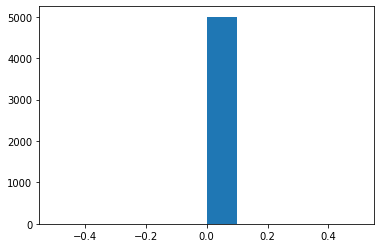

In [213]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


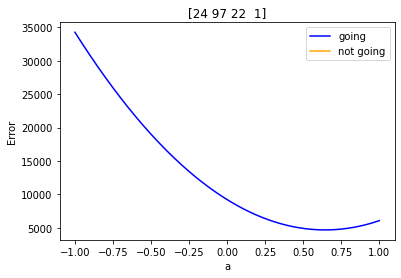

In [219]:
start = cases["1_False"]
plot_errs(start)

Case: 1_False
We expect agents to attend with probability 1.
Total weekly attendance should have mean 100 and variance 0
Average attendance: 100.0
Variance of attendance: 0.0
P-value: 0.0


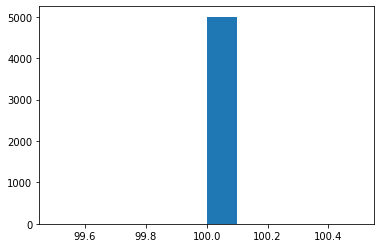

In [220]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

Looks good...

## Case 2

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


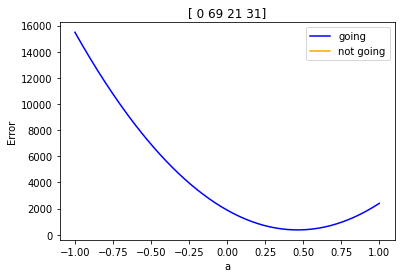

In [221]:
start = cases["2_True"]
plot_errs(start)

Case: 2_True
We expect agents to attend with probability 1.
Total weekly attendance should have mean 100 and variance 0
Average attendance: 100.0
Variance of attendance: 0.0
P-value: 0.0


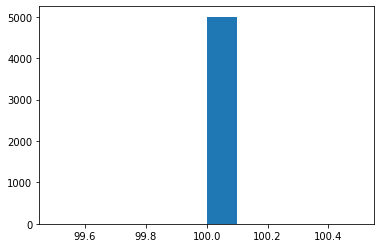

In [222]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


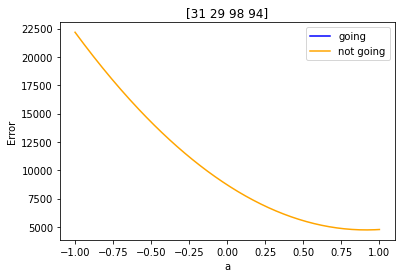

In [223]:
start = cases["2_False"]
plot_errs(start)

Case: 2_False
We expect agents to attend with probability 0.
Total weekly attendance should have mean 0 and variance 0
Average attendance: 0.0
Variance of attendance: 0.0
P-value: 0.0


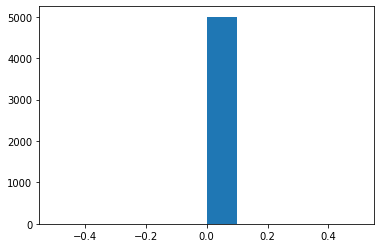

In [224]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

Okay okay...

Now let's try something more interesting like

## Case 3

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


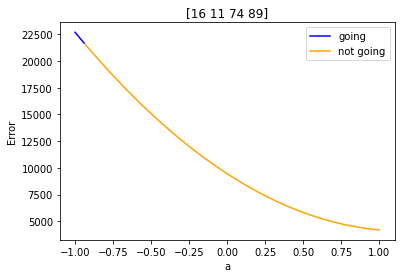

In [225]:
start = cases["3_True"]
plot_errs(start)

Case: 3_True
We expect agents to attend with probability 0.0011111111111110628.
Total weekly attendance should have mean 0.11111111111110628 and variance 0.11098765432098283
Average attendance: 0.1116
Variance of attendance: 0.11114544000000001
P-value: 0.44751739646644934


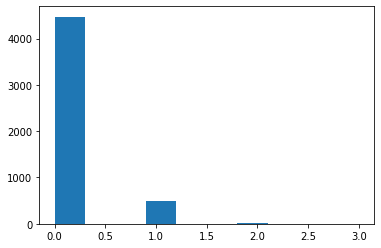

In [226]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


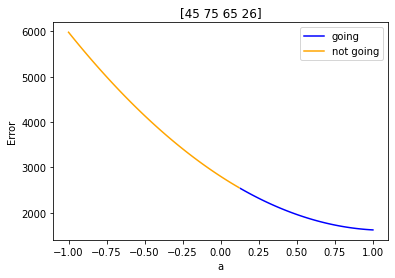

In [227]:
start = cases["3_False"]
plot_errs(start)

Case: 3_False
We expect agents to attend with probability 0.6817882971729126.
Total weekly attendance should have mean 68.17882971729125 and variance 21.69530150109728
Average attendance: 68.1062
Variance of attendance: 22.092521560000005
P-value: 0.13543980161991725


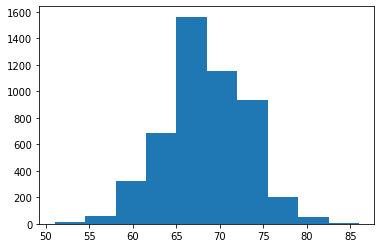

In [228]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

This looks good... Might be worth digging a little more into the distribution later.  How about

## Case 4

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


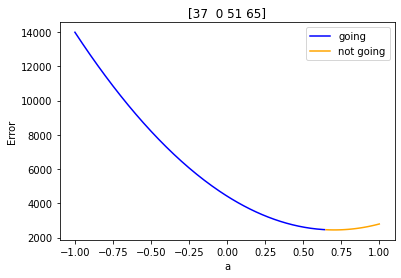

In [229]:
start = cases["4_True"]
plot_errs(start)

Case: 4_True
We expect agents to attend with probability 0.6884092376108741.
Total weekly attendance should have mean 68.84092376108741 and variance 21.450195918288916
Average attendance: 67.627
Variance of attendance: 21.520270999999997
P-value: 1.8663292902357727e-76


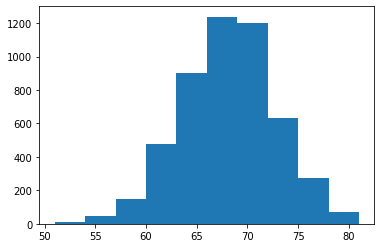

In [230]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


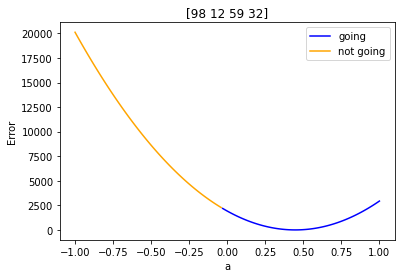

In [231]:
start = cases["4_False"]
plot_errs(start)

Case: 4_False
We expect agents to attend with probability 0.7669906636099126.
Total weekly attendance should have mean 76.69906636099127 and variance 17.87159855451385
Average attendance: 76.578
Variance of attendance: 18.163916
P-value: 0.021566637032263802


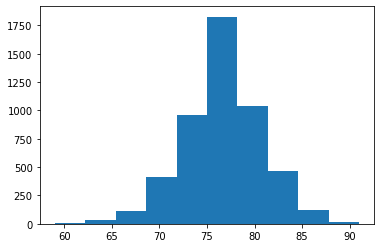

In [232]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

There is DEFINITELY something off with case 4.  Maybe 3 as well.  How about the others?

## Case 5

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


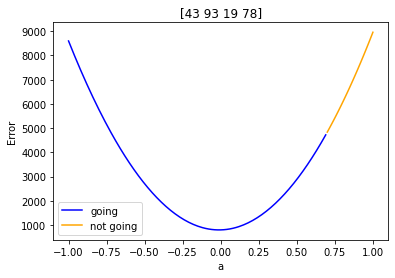

In [233]:
start = cases["5_True"]
plot_errs(start)

Case: 5_True
We expect agents to attend with probability 0.9567768546283218.
Total weekly attendance should have mean 95.67768546283219 and variance 4.135490507585693
Average attendance: 97.0446
Variance of attendance: 2.8410108400000005
P-value: 0.0


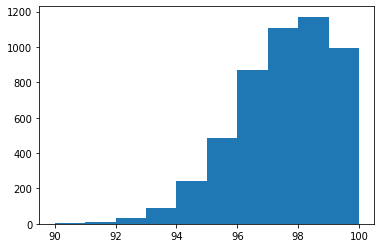

In [234]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


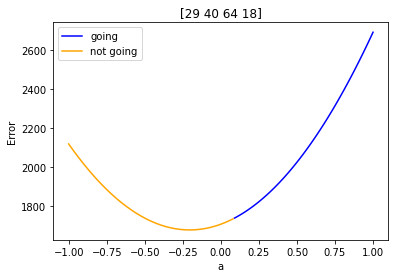

In [235]:
start = cases["5_False"]
plot_errs(start)

Case: 5_False
We expect agents to attend with probability 0.27159231221122826.
Total weekly attendance should have mean 27.159231221122827 and variance 19.782992815898698
Average attendance: 20.8762
Variance of attendance: 16.09727356
P-value: 0.0


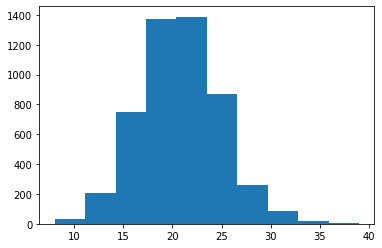

In [236]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

Yeah these are straight up wrong.  Kind of in the ballpark though.

## Case 6

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


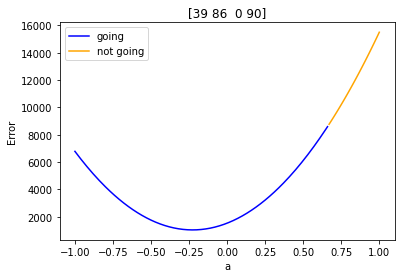

In [243]:
start = cases["6_True"]
plot_errs(start)

Case: 6_True
We expect agents to attend with probability 0.9722222222222222.
Total weekly attendance should have mean 97.22222222222221 and variance 2.7006172839506184
Average attendance: 97.228
Variance of attendance: 2.627616
P-value: 0.400658901862511


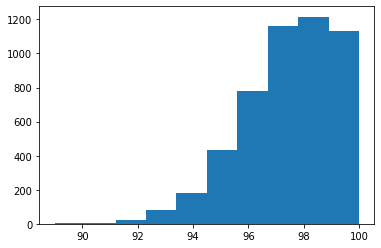

In [244]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

/Users/rebecca/.pyenv/versions/3.9.5/envs/jupyter/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


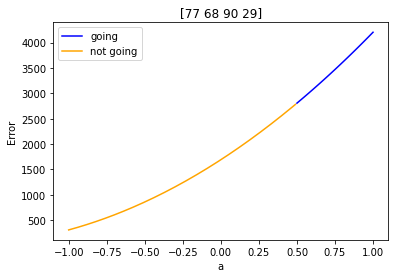

In [245]:
start = cases["6_False"]
plot_errs(start)

Case: 6_False
We expect agents to attend with probability 0.06456597688793331.
Total weekly attendance should have mean 6.45659768879333 and variance 6.039721151644017
Average attendance: 6.4586
Variance of attendance: 5.89588604
P-value: 0.47555188979797597


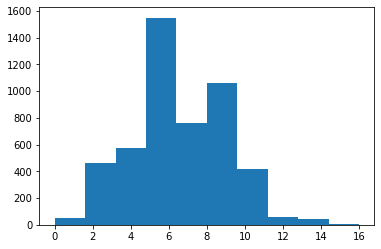

In [246]:
run_test(
    start,
    agents,
    strategies,
    trials,
    seed
)

Okay.   Case 6 looks good.  Something still off with 4 and 5.